In [46]:
import numpy as np
import pandas as pd

df = pd.read_csv('Pivoted_Data_for_Multivariate_Analysis.csv')

In [47]:
df.head()

,Ticker,Date,BookValueofEquity/TotalLiabilities,EBIT/TotalAssets,RetainedEarnings/TotalAssets,Working Capital/Total Assets
0,AFL,2014-12-31,0.181357,0.009465,0.186555,-0.010725
1,AFL,2015-03-31,0.172661,0.009898,0.199445,-0.002042
2,AFL,2015-06-30,0.172206,0.007943,0.199659,0.009033
3,AFL,2015-09-30,0.176115,0.009877,0.203009,0.017834
4,AFL,2015-12-31,0.185818,0.009588,0.192266,0.003514


In [48]:
# Initialize the scaler and scale only the metric columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = df.copy()
data_scaled.iloc[:, 2:] = scaler.fit_transform(data_scaled.iloc[:, 2:])

# Define the sequence length and forecast steps
sequence_length = 10  # Number of historical time steps for each sequence
forecast_steps = 5    # Number of future time steps to forecast

In [49]:
# Prepare sequences for each ticker
def create_multistep_sequences(data, seq_length, forecast_steps):
    X, y = [], []
    for ticker, group in data.groupby("Ticker"):
        ticker_data = group.drop(columns=["Ticker", "Date"]).values
        for i in range(len(ticker_data) - seq_length - forecast_steps + 1):
            X.append(ticker_data[i:i + seq_length])
            y.append(ticker_data[i + seq_length:i + seq_length + forecast_steps])
    return np.array(X), np.array(y)


In [50]:
X, y = create_multistep_sequences(data_scaled, sequence_length, forecast_steps)
print("X shape:", X.shape)  # Should be (num_samples, sequence_length, num_features)
print("y shape:", y.shape)  # Should be (num_samples, forecast_steps, num_features)

X shape: (425, 10, 4)
y shape: (425, 5, 4)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape based on prepared sequences
input_shape = (X.shape[1], X.shape[2])

# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation="relu", input_shape=input_shape),
    Dense(units=forecast_steps * X.shape[2])  # Output layer for multi-step, multi-metric forecast
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Reshape y for training
y_train = y.reshape((y.shape[0], -1))

# Train the model
history = model.fit(X, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/20


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3218 - val_loss: 0.1453
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1480 - val_loss: 0.0366
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 - val_loss: 0.0163
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0156
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0117
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.0089
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0048
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0033
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0027
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0028
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0016
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0021

In [59]:
# Generate predictions for the last few sequences in the dataset to evaluate performance
num_test_sequences = 10  # Number of sequences to test and visualize
X_test = X[-num_test_sequences:]  # Take the last few sequences from X
y_test_actual = y[-num_test_sequences:]  # Corresponding actual future values

# Predict with the model
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((num_test_sequences, forecast_steps, X.shape[2]))

# Rescale predictions and actuals back to original scale for comparison
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, X.shape[2])).reshape(num_test_sequences, forecast_steps, -1)
y_test_actual_rescaled = scaler.inverse_transform(y_test_actual.reshape(-1, X.shape[2])).reshape(num_test_sequences, forecast_steps, -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


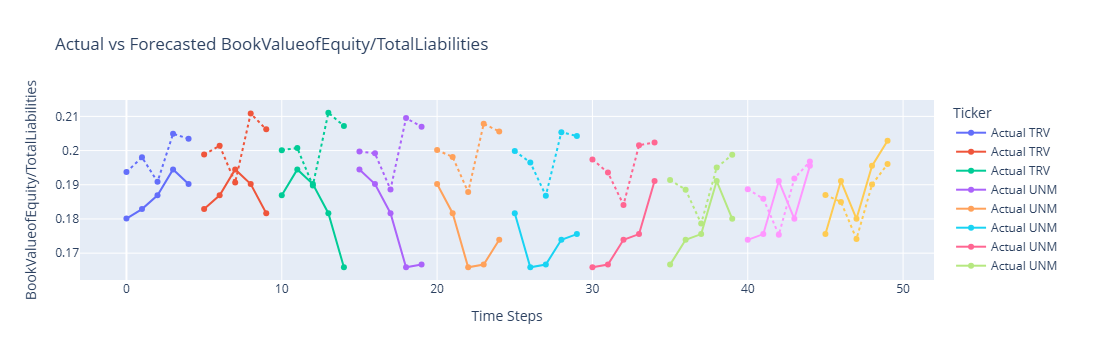

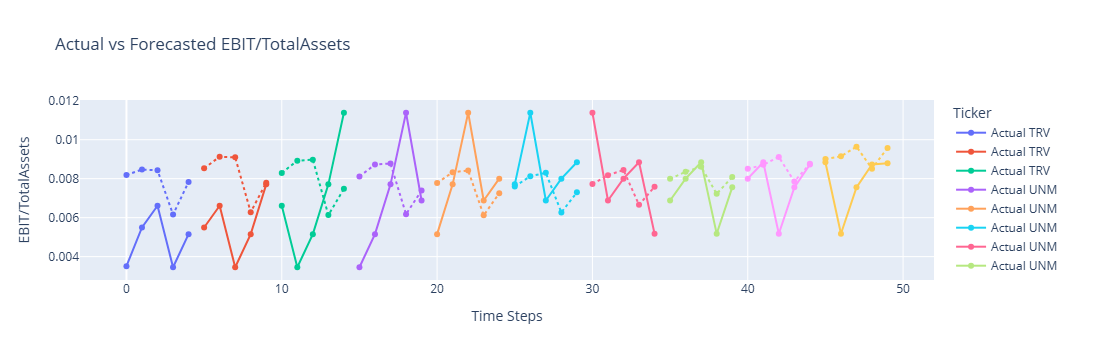

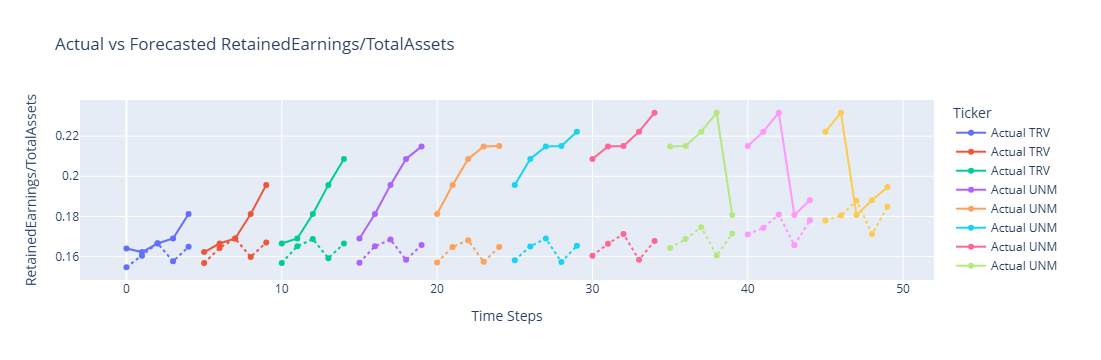

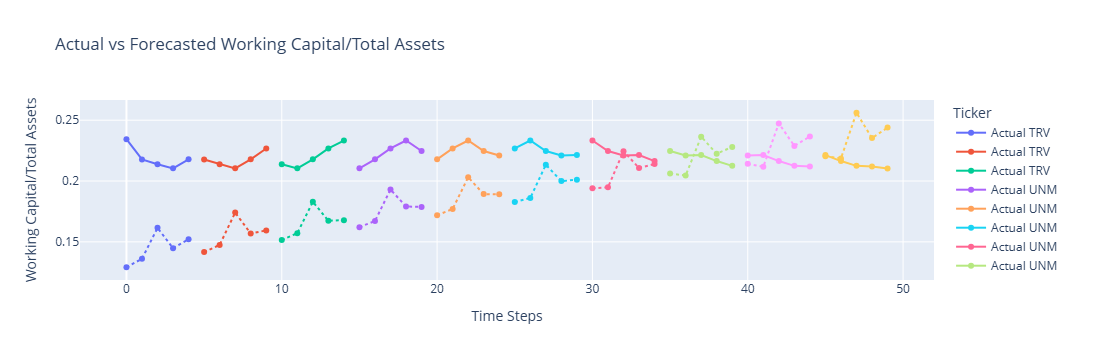

In [69]:
# Plot each metric's actual vs forecasted values for a given sequence
import plotly.graph_objects as go

# Retrieve ticker information for each test sequence
tickers_test = df["Ticker"].iloc[-num_test_sequences * forecast_steps::forecast_steps].values

# Plot each metric's actual vs forecasted values for a given sequence with ticker names in the legend
for metric_idx in range(X.shape[2]):
    metric_name = df.columns[2 + metric_idx]  # Get metric name from column headers
    fig = go.Figure()

    # Plot actual values with ticker names
    for i, ticker in enumerate(tickers_test):
        fig.add_trace(go.Scatter(
            x=np.arange(i * forecast_steps, i * forecast_steps + forecast_steps),
            y=y_test_actual_rescaled[i, :, metric_idx],
            mode='lines+markers',
            name=f"Actual {ticker}"
        ))

    # Plot forecasted values
    for i, ticker in enumerate(tickers_test):
        fig.add_trace(go.Scatter(
            x=np.arange(i * forecast_steps, i * forecast_steps + forecast_steps),
            y=y_pred_rescaled[i, :, metric_idx],
            mode='lines+markers',
            name=f"Forecasted {ticker}",
            line=dict(dash='dot')
        ))

    # Customize layout
    fig.update_layout(
        title=f"Actual vs Forecasted {metric_name}",
        xaxis_title="Time Steps",
        yaxis_title=metric_name,
        legend_title="Ticker"
    )

    # Show the plot
    fig.show()

